In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path
import pprint
import shutil
import img2pdf

from scipy import ndimage
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from glob import glob
from collections import OrderedDict

%matplotlib inline

# Image Processing

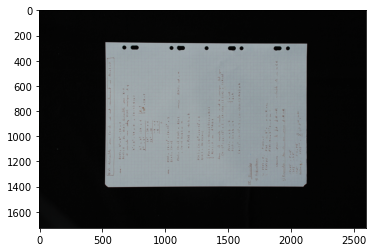

In [2]:
#imgpath= "./_data/scanprepa/Math Spe/Math/Devoirs & Exercices/IMG_2676.JPG"
imgpath = "./_data/scanprepa/Math Sup/Math/Algebre & Geometrie/IMG_3329.JPG"

# to check:
#imgpath = "_data/scanprepa/Math Sup/Math/Devoirs/IMG_3867.JPG"
#imgpath = "./_data/scanprepa/Math Sup/Math/Algebre & Geometrie/IMG_3283.JPG"



img0 = cv2.imread(imgpath)
rotation = -90

plt.imshow(img0)

## Image rotation

CPU times: user 685 ms, sys: 5.12 ms, total: 690 ms
Wall time: 106 ms


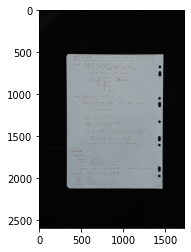

In [3]:
def rotateAboutCenter(src, angle, scale=1.):
    """
    Rotate an image by a given angle.
    """
    h, w, _ = src.shape
    rangle = np.deg2rad(angle)
    # Calculate new image width and height
    nw = (abs(np.sin(rangle)*h) + abs(np.cos(rangle)*w))*scale
    nh = (abs(np.cos(rangle)*h) + abs(np.sin(rangle)*w))*scale
    # Ask OpenCV for the rotation matrix
    rot_mat = cv2.getRotationMatrix2D((nw*0.5, nh*0.5), angle, scale)
    # Combine it with the translation
    rot_move = np.dot(rot_mat, np.array([(nw-w)*0.5, (nh-h)*0.5,0]))
    rot_mat[0,2] += rot_move[0]
    rot_mat[1,2] += rot_move[1]
    return cv2.warpAffine(src, rot_mat,
                          (int(math.ceil(nw)), int(math.ceil(nh))),
                          flags=cv2.INTER_LANCZOS4)

%time img1 = rotateAboutCenter(img0, rotation)

plt.imshow(img1)

## Contour detection

In [4]:
# Some useful functions

def printContoursDetails(contours):
    """
    Prints the details of a contour.
    """
    print("{} contours:".format(len(contours)))
    for i, c in enumerate(contours):
        print(" -{} ({} points): {}".format(i, len(c), str(c).replace('\n', '')))
        
def points2Contour(points):
    """
    Returns a 'contour' based on a list of 2-uplets.
    """
    return np.array([[[p[0], p[1]]] for p in points], dtype='int32')

def contour2Points(contour):
    """
    Returns a list of 2-uplets based on a contour.
    """
    return [(point[0][0], point[0][1]) for point in contour]

def contour2Segments(contour):
    """
    Returns a list of segments, defined by two points based on a contour.
    """
    points = contour2Points(contour)
    nextpoints = points[1:] + points[:1]
    return list(zip(points, nextpoints))

def segments2Contour(segments):
    """
    Returns a 'contour' based on a list of segments.
    """
    points = [s[0] for s in segments]
    return points2Contour(points)
    
def intersection_lines(a1,a2,b1,b2):
    """
    Returns the intersection of two lines, each defined by 2 points.
    """
    x1, y1 = a1
    x2, y2 = a2
    x3, y3 = b1
    x4, y4 = b2
    den = 1.0*(y4-y3)*(x2-x1)-(x4-x3)*(y2-y1)
    if den == 0:
        return None
    num = 1.0*(x4-x3)*(y1-y3)-(y4-y3)*(x1-x3)
    ua = num / den
    return int(x1+ua*(x2-x1)), int(y1+ua*(y2-y1))

def angle(seg1, seg2):
    """
    Return the angle defined by two segments.
    """
    x1 = seg1[1][0]-seg1[0][0]
    y1 = seg1[1][1]-seg1[0][1]
    x2 = seg2[1][0]-seg2[0][0]
    y2 = seg2[1][1]-seg2[0][1]
    normdot = (1.0*x1*x2+y1*y2) / (math.sqrt(x1**2+y1**2)*math.sqrt(x2**2+y2**2))
    return math.degrees(math.acos(normdot))

1 contours:
 -0 (119 points): [[[ 348  523]] [[ 345  526]] [[ 344  526]] [[ 343  527]] [[ 342  527]] [[ 332  537]] [[ 332  538]] [[ 330  540]] [[ 330  541]] [[ 327  544]] [[ 327  545]] [[ 325  547]] [[ 325  549]] [[ 324  550]] [[ 324  568]] [[ 325  569]] [[ 325  677]] [[ 326  678]] [[ 326  780]] [[ 327  781]] [[ 327  890]] [[ 328  891]] [[ 328 1022]] [[ 329 1023]] [[ 329 1184]] [[ 330 1185]] [[ 330 1946]] [[ 329 1947]] [[ 329 2094]] [[ 330 2095]] [[ 330 2096]] [[ 331 2097]] [[ 332 2097]] [[ 333 2098]] [[ 334 2098]] [[ 337 2101]] [[ 338 2101]] [[ 343 2106]] [[ 343 2107]] [[ 346 2110]] [[ 346 2111]] [[ 348 2113]] [[ 348 2114]] [[ 351 2117]] [[ 351 2118]] [[ 353 2120]] [[ 359 2120]] [[ 360 2121]] [[ 516 2121]] [[ 517 2120]] [[ 548 2120]] [[ 549 2121]] [[ 601 2121]] [[ 602 2120]] [[ 608 2120]] [[ 609 2121]] [[ 666 2121]] [[ 667 2120]] [[ 811 2120]] [[ 812 2121]] [[ 826 2121]] [[ 827 2120]] [[ 943 2120]] [[ 944 2121]] [[ 960 2121]] [[ 961 2120]] [[1066 2120]] [[1067 2121]] [[1330 2121]] [[1

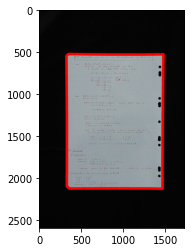

In [5]:
# Find all the contours in the page

def findContours(image):
    """
    Find the contours within the image.
    """
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.erode(img, np.ones((3, 3), np.uint8), iterations=5)
    img = cv2.dilate(img, np.ones((3, 3), np.uint8), iterations=5)
    ret, img = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY)    
    contours, hierarchy = cv2.findContours(img,
                                           cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_SIMPLE)
    return contours


contours = findContours(img1)

# Display
printContoursDetails(contours)
img11 = img1.copy()
cv2.drawContours(img11, contours, -1, (255,0,0), 30)
plt.imshow(img11)


In [6]:
# Filter out contours with small area

minarea = 0.01

def filterOutSmallContours(contours, img, minarea=0.01):
    """
    Filter out contours that have an area below 'minarea'.    
    """
    x, y, _ = img.shape
    minarea = (x * y) * minarea
    return [c for c in contours if cv2.contourArea(c) > minarea]

contours = filterOutSmallContours(contours, img1, minarea)

printContoursDetails(contours)

1 contours:
 -0 (119 points): [[[ 348  523]] [[ 345  526]] [[ 344  526]] [[ 343  527]] [[ 342  527]] [[ 332  537]] [[ 332  538]] [[ 330  540]] [[ 330  541]] [[ 327  544]] [[ 327  545]] [[ 325  547]] [[ 325  549]] [[ 324  550]] [[ 324  568]] [[ 325  569]] [[ 325  677]] [[ 326  678]] [[ 326  780]] [[ 327  781]] [[ 327  890]] [[ 328  891]] [[ 328 1022]] [[ 329 1023]] [[ 329 1184]] [[ 330 1185]] [[ 330 1946]] [[ 329 1947]] [[ 329 2094]] [[ 330 2095]] [[ 330 2096]] [[ 331 2097]] [[ 332 2097]] [[ 333 2098]] [[ 334 2098]] [[ 337 2101]] [[ 338 2101]] [[ 343 2106]] [[ 343 2107]] [[ 346 2110]] [[ 346 2111]] [[ 348 2113]] [[ 348 2114]] [[ 351 2117]] [[ 351 2118]] [[ 353 2120]] [[ 359 2120]] [[ 360 2121]] [[ 516 2121]] [[ 517 2120]] [[ 548 2120]] [[ 549 2121]] [[ 601 2121]] [[ 602 2120]] [[ 608 2120]] [[ 609 2121]] [[ 666 2121]] [[ 667 2120]] [[ 811 2120]] [[ 812 2121]] [[ 826 2121]] [[ 827 2120]] [[ 943 2120]] [[ 944 2121]] [[ 960 2121]] [[ 961 2120]] [[1066 2120]] [[1067 2121]] [[1330 2121]] [[1

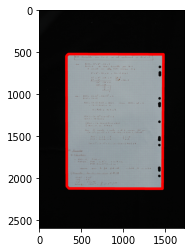

In [7]:
# Build the contour of the page.

def buildContour(contours):
    """
    Build a contour based on the convex hull of the contours in input.
    """
    contour = np.concatenate(contours)
    return cv2.convexHull(contour)

contour = buildContour(contours)

# Display
img111 = img1.copy()
cv2.drawContours(img111, [contour], -1, (255,0,0), 30)
plt.imshow(img111)

1 contours:
 -0 (7 points): [[[1472  526]] [[1461 2124]] [[ 353 2120]] [[ 329 2094]] [[ 324  568]] [[ 327  544]] [[ 348  523]]]


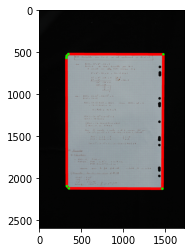

In [8]:
# Approximate the contours

alpha = 0.0005

def approximateContour(contour, alpha=0.0005):
    """
    Approximate the contour by removing useless points.
    """
    return cv2.approxPolyDP(contour, alpha*cv2.arcLength(contour, True), True)

contour = approximateContour(contour, alpha)

# Display
printContoursDetails([contour])    
img13 = img1.copy()
cv2.drawContours(img13, [contour], -1, (255,0,0), 30)
cv2.drawContours(img13, contour, -1, (0,255,0), 30)
plt.imshow(img13)

1 contours:
 -0 (4 points): [[[1472  526]] [[1461 2124]] [[ 329 2119]] [[ 322  522]]]


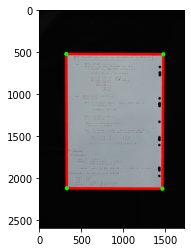

In [9]:
# Remove segments that form broken angles

theta = 5
gamma = .2

def removeBrokenAngles(contour, img, theta=5, gamma=.2):
    """
    Remove broken angle (e.g. folded stappled document).
    - Theta is the angle above which it is not considered a straigh line
    or a 90 degrees angle (90 - theta in this last case).
    - Gamma is the length below which a segment cannot be a broken angle.
    """

    maxBrokenAngleLength = gamma * min(img.shape[:2])
    
    # Retrieve all segments that participate to angles different than 0 or 90 degrees.
    segments = contour2Segments(contour)
    toremove = []
    previous_current_next = list(zip(range(len(segments)),
                                     segments[-1:]+segments[:-1],
                                     segments,
                                     segments[1:]+segments[:1]))    
    for i, prevseg, seg, nextseg in previous_current_next:
        prevangle = abs(angle(prevseg, seg))
        nextangle = abs(angle(seg, nextseg))
        length = math.sqrt((seg[1][0]-seg[0][0])**2+(seg[1][1]-seg[0][1])**2)
        if ((theta < prevangle < 90-theta) and
            (theta < nextangle < 90-theta) and
            (length < maxBrokenAngleLength)):
            toremove.append(i)
    
    # Remove/update segments
    i = 0
    removed = 0
    length = len(segments)
    while i < length:
        iminus, iplus = (i-1)%length, (i+1)%length 
        if i+removed in toremove:
            # Compute intersection of previous & next segments
            (a1, a2) = segments[iminus]
            (b1, b2) = segments[iplus]
            (x, y) = intersection_lines(a1,a2,b1,b2)
            # Update previous & next segments
            segments[iminus] = (segments[iminus][0], (x, y))
            segments[iplus] = ((x, y), segments[iplus][1])
            # Remove current segment
            segments = segments[:i]+segments[i+1:]
            removed += 1
            length -= 1
        else:
            i += 1
        
    return segments2Contour(segments)
 
contour = removeBrokenAngles(contour, img1, theta, gamma)

# Display
printContoursDetails([contour])    
img15 = img1.copy()
cv2.drawContours(img15, [contour], -1, (255,0,0), 30)
cv2.drawContours(img15, contour, -1, (0,255,0), 50)
plt.imshow(img15)

1 contours:
 -0 (4 points): [[[ 322  522]] [[ 329 2119]] [[1461 2124]] [[1472  526]]]


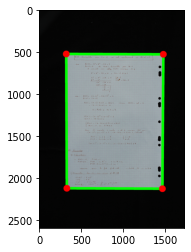

In [10]:
def findCorners(contour):
    """
    Find the 4 corners of a page in a contour.
    """
    v1 = [i[0][0]+i[0][1] for i in contour]
    topleft = v1.index(min(v1))
    bottomright = v1.index(max(v1))
    v2 = [i[0][0]-i[0][1] for i in contour]
    bottomleft = v2.index(min(v2))
    topright = v2.index(max(v2))
    ordered_indexes = [topleft, bottomleft, bottomright, topright]
    ordered_contour = np.array([contour[i] for i in ordered_indexes])
    return ordered_contour

contour = findCorners(contour)

#Display
printContoursDetails([contour])
imgt = img1.copy()
cv2.drawContours(imgt, [contour], -1, (0,255,0), 30)
cv2.drawContours(imgt, contour, -1, (255,0,0), 80)
plt.imshow(imgt)

## Determine 'A4' equivalent zone in the picture

In [11]:
def computeA4subarea(img):
    """
    Return the dimension (rows, cols) of the biggest subarea
    of the image that would have the same proportion than an
    A4 page.
    """
    rows, cols, ch = img.shape
    rowsA4, colsA4 = 297, 210
    newrows, newcols = rows, cols
    if 1.0*rows/cols > rowsA4/colsA4:
        newrows = int(1.0 * cols * rowsA4 / colsA4)
    else:
        newcols = int(1.0 * rows * colsA4 / rowsA4)
    return newrows, newcols

newrows, newcols = computeA4subarea(img1)

# Display
rows, cols, ch = img1.shape
print("image dimension:    ", rows, cols)
print("proposed dimension: ", newrows, newcols)


image dimension:     2592 1729
proposed dimension:  2445 1729


## Change the perspective of the image to fit the 'A4' zone of the page

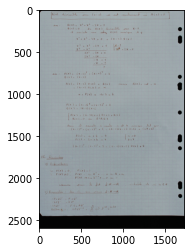

In [12]:
def reframePage(contour, img, rows, cols):
    """
    Reframe the image to have the contour taking all the space.
    """
    # The points that will define the transformation
    pts_origin = np.float32(contour)
    pts_destination = np.float32([[0,0],
                                  [0,rows],
                                  [cols,rows],
                                  [cols,0]])
    # Apply the transformation
    imgrows, imgcols, _ = img1.shape
    M = cv2.getPerspectiveTransform(pts_origin, pts_destination)
    newimg = cv2.warpPerspective(img, M, (imgcols,imgrows))
    return newimg
    
img2 = reframePage(contour, img1, newrows, newcols)    
    
#cv2.imwrite("out2.jpg", img2)
plt.imshow(img2)

## Crop the image to keep only the 'A4' zone

(2445, 1729, 3)


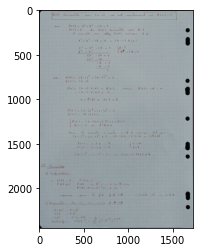

In [13]:
def cropImage(img, rows, cols):
    return img[0:rows, 0:cols]
    
img3 = cropImage(img2, newrows, newcols)

# Display
print(img3.shape)
plt.imshow(img3)

## Improve the contrast (todo)

In [15]:
#def improveContrast(img):
#    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#    return clahe.apply(img)

#img4 = improveContrast(img3)

# Display
#plt.imshow(img4)

# Batch processing

In [16]:
def detectPage(img, alpha=0.0005, theta=10, gamma=0.2, minarea=0.01):
    """
    Return the contour of the page within the image file.
    """
    contours = findContours(img)
    contours = filterOutSmallContours(contours, img, minarea)
    contour = buildContour(contours)
    contour = approximateContour(contour, alpha)
    contour = removeBrokenAngles(contour, img, theta, gamma)
    contour = findCorners(contour)
    return contour

def reframeImage(img, contour):
    """
    Reframe the image based on the contour of the page.
    """
    rows, cols = computeA4subarea(img)
    img = reframePage(contour, img, rows, cols)
    img = cropImage(img, rows, cols)
    return img

In [17]:
def processFile(imgpath, outdir, rotation=0, alpha=0.005, theta=5, gamma=0.2, minarea=0.01):
    """
    Process an image file.
    """
    basename = os.path.basename(imgpath)
    # Read image, rotate it, detect the contour, reframe it and save it.
    img = cv2.imread(imgpath)
    img = rotateAboutCenter(img, rotation)
    contour = detectPage(img, alpha, theta, gamma, minarea)
    newimg = reframeImage(img, contour)
    outfile = os.path.join('./', outdir, basename)
    cv2.imwrite(outfile, newimg)
    return newimg, outfile, contour

In [18]:
def processDirectory(indir, outdir, rotation=0):
    """
    From a directory 'indir' filled with jpg files, generate another directory 'outdir'
    with the same picture reframed to fit the contained sheet.
    """
    # Retrieve all jpg files in the directory
    imgpaths = glob(os.path.join(indir, '*'))
    imgpaths.sort()
    imgpaths = [p for p in imgpaths if p[-4:].lower() == ".jpg"]

    # Build out directory
    #shutil.rmtree(outdir, ignore_errors=True)
    os.makedirs(outdir)
    
    # Process images
    images = {}
    for imgpath in imgpaths:
        basename = os.path.basename(imgpath)
        img, outfile, contour = processFile(imgpath, outdir, rotation=rotation)
        images[basename] = {"contour": str(contour2Points(contour)),
                            "rotation": rotation}

    # Save metadata
    with open(os.path.join(outdir, 'metadata.py'), 'w') as out:
        pprint.pprint(images, width=200, stream=out)

In [19]:
def createPdf(directory, pdfpath):
    """
    Create a PDF file fromc a directory.
    The jpg files in the directory will compose the page of the document generated.
    The name of the PDF file is the name of the directory.
    """
    images = os.listdir(directory)
    images = [os.path.join(directory, i) for i in images if i[-4:].lower() == ".jpg"]
    images.sort()
    with open(pdfpath, "wb") as f:
        f.write(img2pdf.convert(images))

In [21]:
inputData = "./_data"
outputDir = "./_out"
ignoreDirs = ['black', 'canon 2']

shutil.rmtree(outputDir)

for root, dirs, files in os.walk(inputData, topdown=False):
    for name in dirs:
        path = os.path.join(root, name)
        # Ignore if the directory contains subdirectories
        containsdir = any([os.path.isdir(os.path.join(path, e)) for e in os.listdir(path)])
        if containsdir:
            continue
        if name in ignoreDirs:
            continue
        print("Processing {} from {}".format(name, path))
        # Process all images in the directory
        destDir = os.path.join(outputDir, name)
        processDirectory(path, destDir, rotation=-90)
        # Generate the pdf file
        createPdf(destDir, destDir+".pdf")

Processing others from ./_data/categorized/others
Processing simple from ./_data/categorized/simple
Processing damaged from ./_data/categorized/damaged
Processing double from ./_data/categorized/double
Processing Programme from ./_data/scanprepa/Math Sup/Math/Programme
Processing Devoirs from ./_data/scanprepa/Math Sup/Math/Devoirs
Processing Algebre & Geometrie from ./_data/scanprepa/Math Sup/Math/Algebre & Geometrie
Processing Analyse from ./_data/scanprepa/Math Sup/Math/Analyse
Processing Formulaires from ./_data/scanprepa/Math Sup/Math/Formulaires
Processing Devoirs & Exercices from ./_data/scanprepa/Math Spe/Math/Devoirs & Exercices
Processing Cours from ./_data/scanprepa/Math Spe/Math/Cours
Processing titre sejour from ./_data/raw/titre sejour
Processing canon 3 from ./_data/raw/canon 3
Processing iphone from ./_data/raw/iphone
Processing canon 1 from ./_data/raw/canon 1



# Metadata

In [ ]:
# Meta data

# Read meta data if present
#with open(os.path.join(indir, "metadata.py"), "r") as data:
#    metadata = eval(data.read())
        
# Save meta data
# Generate meta data


# Contrast

In [ ]:
def improveContrast(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)

img = improveContrast(img)
    
